In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#wmt modes
process_gen_modes=["wmt_samples0"]


#5 threads for llama1, 

processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
compare_metric="example_comet"
examples_df, completions_df=get_dfs(processGens)


dfs_by_model={}
for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model
df=next(iter(dfs_by_model.values()))

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['wmt_samples0']
calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_1000/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_100_eval_1000
get_metrics_dict
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'rank', 'suite', 'instanceID', 'text', 'completion_length',
       'output_logprob', 'isCompletion'],
      dtype='object')
Num examples: 100000
Num completions: 1000


num examples 100000
num_completions 1000
compare_metric mean:  example_comet    0.746246
dtype: float64
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'rank', 'suite', 'instanceID', 'text', 'completion_length',
       'output_logprob', 'isCompletion'],
      dtype='object')


<Axes: >

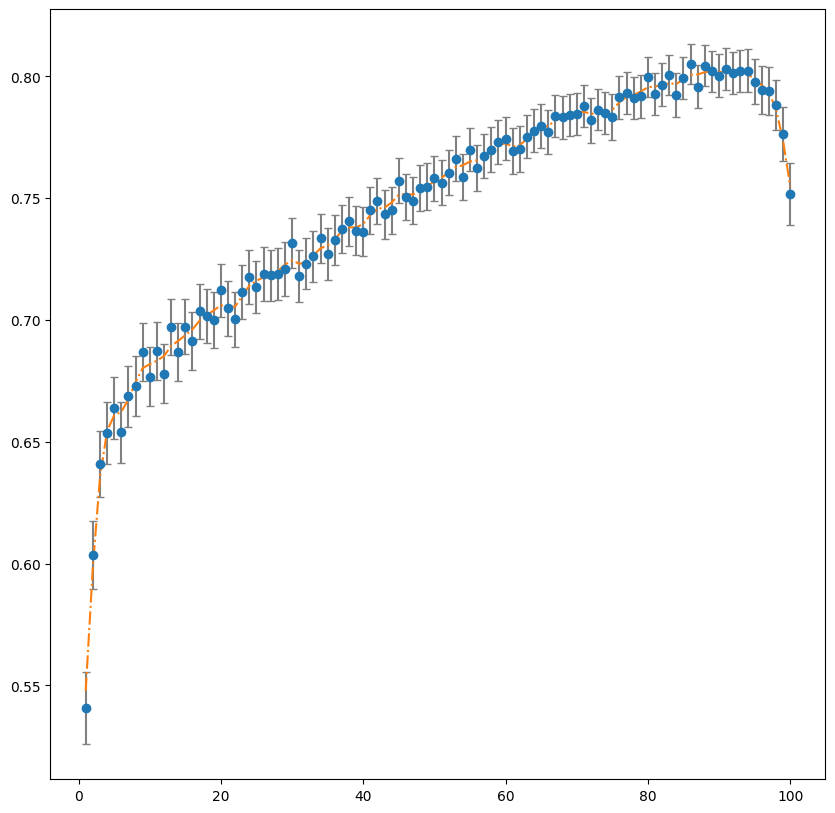

In [2]:
# print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
#     f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# # instanceGeneration=get_first(processGens.first_run_instances)
# print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
print(df.columns)
plot_smooth_spline(df=df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title="", error_bar=True, figsize=(10,10))



In [29]:
#create dicts
num_ranks=100
pivoted = df.pivot(index="instanceID",columns="rank", values=compare_metric )
mean_pivoted=pivoted.mean()
median_pivoted=pivoted.median()

grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()



X=df["rank"].values.reshape(-1,1).astype(np.float64)
x=X.reshape(-1)
y=df[compare_metric].values.reshape(-1).astype(np.float64)
metrics={"model_name":model_name}

First, establish the basic facts

In [30]:

#expectation: 
# best_rank=84
# rank100=.75
# rank0=0.53
# corr=positive

ave_val=float(mean_pivoted.mean())
metrics["ave_val"]=ave_val

best_rank = mean_pivoted.idxmax()


metrics["0_score"]= float(mean_pivoted[1])
metrics["100_score"]= float(mean_pivoted[100])
metrics["100_median"]=float(median_pivoted[100])

metrics["best_rank"]=int(best_rank)
metrics["best_score"]=float(mean_pivoted[best_rank])
metrics["best_median"]=float(median_pivoted[100])



def get_win_rate(row, col1:str, col2:str) -> float:
    if row[col1]==row[col2]:
        return 0.5
    return float((row[col1] - row[col2])>0)


pivoted["win_rate_of_best"] = pivoted.apply( lambda row: get_win_rate(row,best_rank, 100) , axis=1)
win_rate=pivoted["win_rate_of_best"].mean()
metrics["win_rate"]=win_rate




Correlation and linear regress

In [31]:
from dcor import distance_correlation
dcor = distance_correlation(X, y)
metrics["dcor"]=float(dcor)


Gam Metrics

In [32]:

from sklearn.metrics import r2_score




# Assuming df is your dataframe
X = grouped["rank"].values.reshape(-1,1)
y = grouped[compare_metric].values.reshape( -1)


gam = LinearGAM(s(0)).gridsearch(X, y)


#R2
y_pred = gam.predict(X)
r2 = r2_score(y,  gam.predict(X))
metrics["r2"]=r2


#find peak
all_x=np.linspace(0,100,1000)
all_y_pred=gam.predict(all_x)
argmax_idx=np.argmax(all_y_pred)
pred_peak_x=all_x[argmax_idx]
pred_peak_y=all_y_pred[argmax_idx]
metrics["pred_peak_x"]=float(pred_peak_x)
metrics["pred_peak_y"]=float(pred_peak_y)
metrics["pred_100"]=float(gam.predict(100)[0])



gam_ave_diff= np.mean(np.abs(all_y_pred-ave_val))

metrics["gam_ave_diff"]=float(gam_ave_diff)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [33]:
def get_grouped_name(model_name):
    clean = re.sub(r"[/\\?%*:|\"<>\x7F\x00-\x1F]", "-", model_name)
    return clean


grouped.to_pickle(get_grouped_name(model_name))
grouped = pd.read_pickle(get_grouped_name(model_name))

In [43]:
# print(metrics)
metrics_dict=pd.DataFrame(metrics,  index=[0])
print(metrics_dict.head(1))




                         model_name   ave_val   0_score  100_score  \
0  meta_llama_Llama_3.1_8B_Instruct  0.746246  0.540629   0.751664   

   100_median  best_rank  best_score  best_median  win_rate     dcor  \
0    0.837979         86    0.805062     0.837979    0.4795  0.25948   

         r2  pred_peak_x  pred_peak_y  pred_100  gam_ave_diff  
0  0.992971    91.591592     0.802079  0.755765      0.040607  
